In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Boosting FSS via SAM

In [2]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [3]:
using_colab = False

In [4]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


## Example image

## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [26]:
#vit_h, largest and best performance
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [23]:
#vib_b. efficient and normal performance
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "../sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

To select the truck, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

Predict with `SamPredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

With `multimask_output=True` (the default setting), SAM outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

In [14]:
#number list way
import os
import cv2
from pathlib import Path

image_list = []
path = '../../BAM-main/visual/query/'
path1 = 'visual/output/'
path2 = 'visual/label/'
path3 = 'visual/label2/'

num_files = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
print('num_files',num_files)



for i in range(num_files):
    image_t = cv2.imread(path + str(i) + '.jpg', cv2.COLOR_BGR2RGB)
    image_t = cv2.cvtColor(image_t, cv2.COLOR_BGR2RGB)
    image_t = cv2.resize(image_t, (500, 500))
    image_list.append(image_t)

fssmask_list = []
for i in range(num_files):
    mask_t = cv2.imread('../../BAM-main/visual/output/' + str(i) + '.jpg', cv2.IMREAD_GRAYSCALE)
    mask_t = cv2.resize(mask_t, (500, 500))
    fssmask_list.append(mask_t)

gt_list = []
for i in range(num_files):
    mask_gt = cv2.imread('../../BAM-main/visual/label/' + str(i) + '.jpg', cv2.IMREAD_GRAYSCALE)
    mask_gt2 = cv2.imread('../../BAM-main/visual/label2/' + str(i) + '.jpg', cv2.IMREAD_GRAYSCALE)
    mask_gt = cv2.resize(mask_gt, (500, 500))
    mask_gt2 = cv2.resize(mask_gt2, (500, 500))
    mask_final = cv2.absdiff(mask_gt2, mask_gt) 
    # cv2.imwrite('visual/new/' + str(i)+'.jpg', mask_final)
    gt_list.append(mask_final)

maskpt_list = []
for i in range(num_files):
    maskpt = torch.load('../../BAM-main/visual/outputpt/' + str(i)  + '.pt')
    maskpt_list.append(maskpt)

# gt_list_base = []
# for i in range(num_files):
#     mask_gt = cv2.imread('../../Boosting/visual_dataset/res50-split0/label/' + str(i) + '.jpg', cv2.IMREAD_GRAYSCALE)
#     mask_gt2 = cv2.imread('../../Boosting/visual_dataset/res50-split0/label2/' + str(i) + '.jpg', cv2.IMREAD_GRAYSCALE)
#     mask_gt = cv2.resize(mask_gt, (500, 500))
#     mask_gt2 = cv2.resize(mask_gt2, (500, 500))
#     mask_final = cv2.absdiff(mask_gt2, mask_gt) 
#     # cv2.imwrite('visual/new/' + str(i)+'.jpg', mask_final)
#     gt_list_base.append(mask_gt)

# gt_list_l = []
# for i in range(num_files):
#     mask_gt = cv2.imread('../../Boosting/visual_dataset/res50-split0/label/' + str(i) + '.jpg', cv2.IMREAD_GRAYSCALE)
#     mask_gt2 = cv2.imread('../../Boosting/visual_dataset/res50-split0/label2/' + str(i) + '.jpg', cv2.IMREAD_GRAYSCALE)
#     mask_gt = cv2.resize(mask_gt, (500, 500))
#     mask_gt2 = cv2.resize(mask_gt2, (500, 500))
#     mask_final = cv2.absdiff(mask_gt2, mask_gt) 
#     # cv2.imwrite('visual/new/' + str(i)+'.jpg', mask_final)
#     gt_list_l.append(mask_gt2)
print(len(fssmask_list))
print(len(gt_list))
# print(len(gt_list_base))
print(len(image_list))

num_files 1000
1000
1000
1000


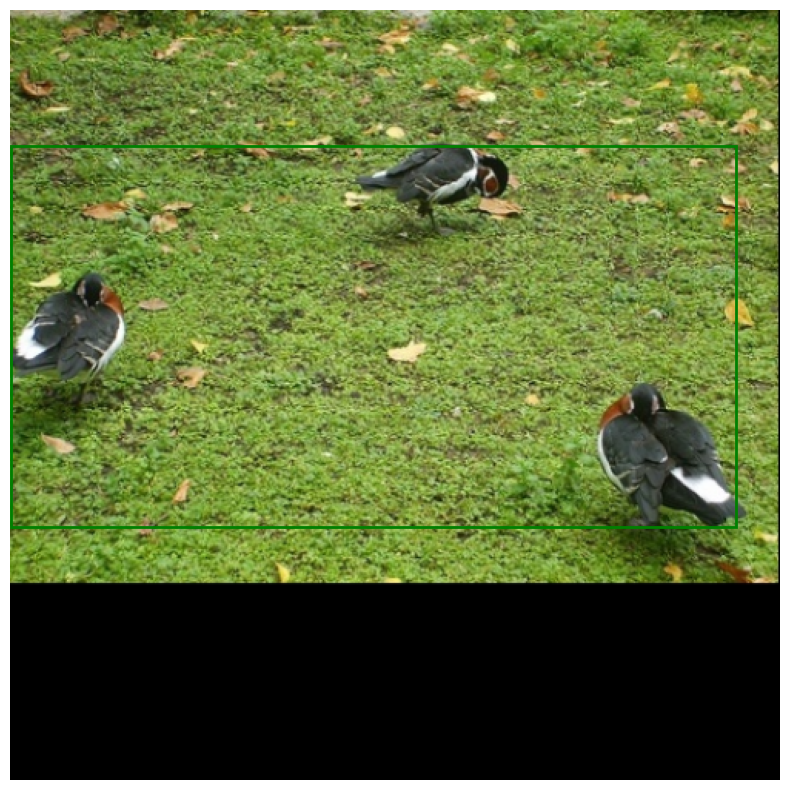

1000


In [15]:
import numpy as np
box_list = []
# print(fssmask_list[363])
for i in range(num_files):
    im = fssmask_list[i]
    # Segmentation color value (in Blender this is likely your pass index)
    seg_value = 1
    if im is not None:
        np_seg = np.array(im)
        segmentation = np.where(np_seg == seg_value)
        # Bounding Box
        bbox = 0, 0, 0, 0
        if len(segmentation) != 0 and len(segmentation[1]) != 0 and len(segmentation[0]) != 0:
            x_min = int(np.min(segmentation[1]))
            x_max = int(np.max(segmentation[1]))
            y_min = int(np.min(segmentation[0]))
            y_max = int(np.max(segmentation[0]))
            # bbox = x_min, y_min, x_max, y_max
            box_list.append([x_min, y_min, x_max, y_max])
        else:
            box_list.append([0, 0, 400, 400])

# print(bbox)
plt.figure(figsize=(10, 10))
plt.imshow(image_list[60]) #fssmask_list,image_list
bbox = np.array([[box_list[60][0],box_list[60][1],box_list[60][2],box_list[60][3]]])
for box in bbox:
    show_box(box, plt.gca())

plt.axis('off')
plt.show()
print(len(box_list))

In [27]:
#center

center_list = []
box_list_final = []
for k in range(num_files):

    # Calculate the moments of the binary image
    # M = cv2.moments(fssmask_list[i])
    # # Calculate the center coordinate of the binary mask
    # x_c = M['m10'] / (M['m00'] + 1e-7)
    # y_c = M['m01'] / (M['m00'] + 1e-7)
    contours,_ = cv2.findContours(fssmask_list[k].copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_L1)

    centres = []
    box = []
    for i in range(len(contours)):
        if cv2.contourArea(contours[i]) < 2000:
            continue
        moments = cv2.moments(contours[i])
        centres.append((int(moments['m10']/(moments['m00']+1e-7)), int(moments['m01']/(moments['m00']+1e-7))))
    
        x, y, w, h = cv2.boundingRect(contours[i])
        # print(f"Bounding Box: x={x}, y={y}, w={w}, h={h}")
        box.append([x, y, x+w, y+h])
        # print(box)
    if not box:
        box = [0,0,500,500]
        #prevent too many boxes which could be noise
    if len(box)>5:
        box_list_final.append(box_list[k])
    else:
        box_list_final.append(box)
    # print(len(box))
    centres = [[p for p in pair] for pair in centres]

    if not centres:
        centres = [[255,255]]
    #print(len(centres))
    center_list.append(centres)
print(len(center_list[60]))     
print(center_list[60])     
print(len(center_list))

3
[[423, 290], [40, 209], [282, 109]]
1000


In [28]:
#center

point_list = []
label_list = []
boxes_list = []
for i in range(num_files):
    point = torch.tensor([center_list[i]], device=sam.device)
    box = torch.tensor(box_list_final[i], device=sam.device)
    boxes_list.append(box)
    point_list.append(point)
    a = [1] * len(center_list[i])
    alist = list(a)
    # print(alist)
    label = torch.tensor([alist], device=sam.device)
    label_list.append(label)
print(point_list[113])
print(boxes_list[113])

tensor([[[329, 317]]], device='cuda:0')
tensor([[227, 261, 410, 364]], device='cuda:0')


Both images and prompts are input as PyTorch tensors that are already transformed to the correct frame. Inputs are packaged as a list over images, which each element is a dict that takes the following keys:
* `image`: The input image as a PyTorch tensor in CHW format.
* `original_size`: The size of the image before transforming for input to SAM, in (H, W) format.
* `point_coords`: Batched coordinates of point prompts.
* `point_labels`: Batched labels of point prompts.
* `boxes`: Batched input boxes.
* `mask_inputs`: Batched input masks.

If a prompt is not present, the key can be excluded.

In [29]:
from segment_anything.utils.transforms import ResizeLongestSide
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device.device) 
    return image.permute(2, 0, 1).contiguous()
print(num_files)

1000


In [31]:
# batch_size = 4
# new_output = []
# for i in range(0, int(num_files/batch_size)):
#     batched_input = []
#     for p in range(batch_size):
#         if (p + batch_size * i < num_files):
#             inputi = { 'image': prepare_image(image_list[p + batch_size * i], resize_transform, sam),
#                     'point_coords': resize_transform.apply_coords_torch(point_list[p + batch_size * i], image_list[p + batch_size * i].shape[:2]),
#                     'point_labels': label,
#                     'original_size': image_list[0].shape[:2]
#                     }
#             batched_input.append(inputi)
#     batched_output = sam(batched_input, multimask_output=False)
#     for q in range(batch_size):
#         for mask in batched_output[q]['masks']:
#             save_mask = mask.cpu().numpy().transpose(1, 2, 0)
#             save_mask= save_mask.view(np.uint8)
#             new_output.append(save_mask)
#             cv2.imwrite('output/' + str(q + batch_size * i) + '.jpg', save_mask*255) 
   
batch_size = 1
new_output = []
for i in range(0, int(num_files/batch_size)):
    batched_input = []
    for p in range(batch_size):
        if (p + batch_size * i < num_files):
            inputi = { 'image': prepare_image(image_list[p + batch_size * i], resize_transform, sam),
                    'boxes': resize_transform.apply_boxes_torch(boxes_list[p + batch_size * i], image_list[p + batch_size * i].shape[:2]),
                    #'point_coords': resize_transform.apply_coords_torch(point_list[p + batch_size * i], image_list[p + batch_size * i].shape[:2]),
                    #'point_labels': label_list[p + batch_size * i],
                    'original_size': image_list[0].shape[:2]
                    }
            print(i)
            batched_input.append(inputi)
    batched_output = sam(batched_input, multimask_output=False)
    for q in range(batch_size):
        for mask in batched_output[q]['masks']:
            save_mask = mask.cpu().numpy().transpose(1, 2, 0)
            save_mask= save_mask.view(np.uint8)
            cv2.imwrite('output/' + str(q + batch_size * i) + '.jpg', save_mask*255) 
            torch.save(mask, 'outputpt/' + str(q + batch_size * i) + '.pt')


# _input = [
#      {
#          'image': prepare_image(image1, resize_transform, sam),
#          'boxes': resize_transform.apply_boxes_torch(image1_boxes, image1.shape[:2]),
#          'original_size': image1.shape[:2]
#      },
#      {
#          'image': prepare_image(image2, resize_transform, sam),
#          'point_coords': resize_transform.apply_coords_torch(input2_point, image2.shape[:2]),
#          'point_labels': input2_label,
#          'original_size': image2.shape[:2]
#      }
# ]



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155


KeyboardInterrupt: 

Run the model.

Evaluate mIOU

In [25]:
new_output_sam = []
num = 0
sam_list = []
for i in range(num_files):
    image_t = cv2.imread('output/' + str(i) + '.jpg', cv2.IMREAD_GRAYSCALE)
    sam_list.append(image_t)
    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)) 
    # image_t = cv2.morphologyEx(image_t, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # kernel = np.ones((5, 5), np.uint8) 
    # img_erosion = cv2.erode(image_t, kernel, iterations=1) 
    # img_dilation = cv2.dilate(image_t, kernel, iterations=1) 
    # image_t = img_dilation
    image_t_pt = torch.load('outputpt/' + str(i) + '.pt')
    image_t_pt = torch.from_numpy(image_t)
    intersection_judge = np.logical_and(image_t, fssmask_list[i])
    union_judge = np.logical_or(image_t, fssmask_list[i])
    confidence = np.sum(intersection_judge) / np.sum(union_judge)
    if confidence > 0.7:
        # image_t = np.logical_and(image_t, fssmask_list[i])
        image_t_pt = torch.from_numpy(image_t)
        image_t_pt = image_t_pt.unsqueeze(0)
        new_output_sam.append(image_t)
        cv2.imwrite('output2/' + str(i) + '.jpg', image_t*255)
        torch.save(image_t_pt, '../../BAM-main/output2pt/' + str(i) + '.pt')
        num+=1
    else:
        new_output_sam.append(fssmask_list[i])
        cv2.imwrite('output2/' + str(i) + '.jpg', fssmask_list[i])
        torch.save(maskpt_list[i], '../../BAM-main/output2pt/' + str(i) + '.pt')
    

print(num) 
# print(new_output[0].shape)
iou_score = 0
iou_score_new = 0
iou_score_new2 = 0
intersection_all = 0 
union_all = 0
intersection_all_new = 0 
union_all_new2 = 0
intersection_all_new2 = 0 
union_all_new = 0
for i in range(num_files):
    intersection = np.logical_and(gt_list[i], fssmask_list[i])
    union = np.logical_or(gt_list[i], fssmask_list[i])
    intersection_all += intersection
    union_all += union
    iou_score += np.sum(intersection) / np.sum(union)
    
    intersection_new = np.logical_and(gt_list[i], new_output_sam[i])
    union_new = np.logical_or(gt_list[i], new_output_sam[i])
    intersection_all_new += intersection_new
    union_all_new += union_new
    iou_score_new += np.sum(intersection_new) / np.sum(union_new)

    intersection_new2 = np.logical_and(gt_list[i], sam_list[i])
    union_new2 = np.logical_or(gt_list[i], sam_list[i])
    intersection_all_new2 += intersection_new2
    union_all_new2 += union_new2
    iou_score_new2 += np.sum(intersection_new2) / np.sum(union_new2)


# iou_score = np.sum(intersection_all) / np.sum(union_all)
# iou_score_new = np.sum(intersection_all_new) / np.sum(union_all_new)
# iou_score_new2 = np.sum(intersection_all_new2) / np.sum(union_all_new2)
iou_score = np.sum(iou_score) / np.sum(num_files)
iou_score_new = np.sum(iou_score_new) / np.sum(num_files)
iou_score_new2 = np.sum(iou_score_new2) / np.sum(num_files)

print("FSS_mIoU:",iou_score)
print("SAM_mIoU:",iou_score_new2)
print("EFSAM_mIoU:",iou_score_new)

541
FSS_mIoU: 0.5857963151401935
SAM_mIoU: 0.5472710829464793
EFSAM_mIoU: 0.5951880119898844


The output is a list over results for each input image, where list elements are dictionaries with the following keys:
* `masks`: A batched torch tensor of predicted binary masks, the size of the original image.
* `iou_predictions`: The model's prediction of the quality for each mask.
* `low_res_logits`: Low res logits for each mask, which can be passed back to the model as mask input on a later iteration.

220
Bounding Box: x=376, y=240, w=96, h=96
Bounding Box: x=0, y=168, w=80, h=80
Bounding Box: x=224, y=88, w=104, h=48
[(423, 290), (40, 209), (282, 109)]
3


True

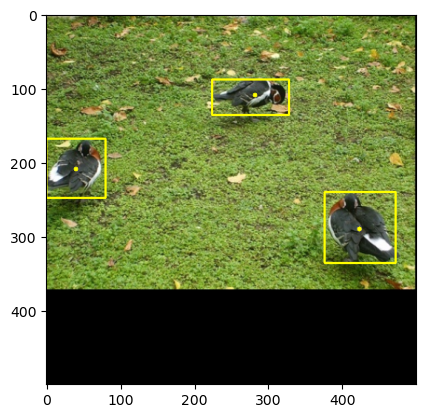

In [ ]:
#multi object
img = fssmask_list[60] 
image = image_list[60]
contours,_ = cv2.findContours(img.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_L1)
print(len(contours))
centres = []
for i in range(len(contours)):
  if cv2.contourArea(contours[i]) < 1000:
    continue
  moments = cv2.moments(contours[i])
  centres.append((int(moments['m10']/moments['m00']), int(moments['m01']/moments['m00'])))
  cv2.circle(image, centres[-1], 3, (255, 255, 0), -1)


  x, y, w, h = cv2.boundingRect(contours[i])
  cv2.rectangle(image, (x, y), (x + w, y + h), (255, 255, 0), 2)
  print(f"Bounding Box: x={x}, y={y}, w={w}, h={h}")


print(centres)
print(len(centres))
# cv2.imshow('image', img)
plt.imshow(image) #fssmask_list,image_list
# plt.imshow(image_list[60])
cv2.imwrite('output.png',img)
# cv2.waitKey(0)